In [6]:
import json

import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np
from util import metrics

In [7]:
# embedding model
model = SentenceTransformer("all-MiniLM-L12-v2")

In [8]:
# create vector store
from langchain_core.vectorstores import InMemoryVectorStore


class SentenceTransformerEmbeddings:
    def __init__(self, st_model):
        self.model = st_model

    def embed_documents(self, texts):
        return self.model.encode(texts)

    def embed_query(self, text):
        return self.model.encode(text)


# Create an instance of the embeddings class
embeddings = SentenceTransformerEmbeddings(model)
vector_store = InMemoryVectorStore(embeddings)

In [9]:
from pathlib import Path
from langchain_core.documents import Document

# load the dataset
txt_dir = Path("../data/txt")
qa_dir = Path("../data/generated")

document_chunks = []
doc_question_answers = {}

# load documents together with their question-answer pairs (and references)
for doc_file in txt_dir.iterdir():
    print(f"Processing {doc_file.name}...")
    if doc_file.suffix == ".txt":
        doc_name = doc_file.stem
        with open(doc_file, "r") as f:
            text = f.read()

        # load the corresponding queries
        qa_file = qa_dir / f"{doc_name}_qa_pairs_with_refs.json"
        if not qa_file.exists():
            print(f"Warning: {qa_file} does not exist. Skipping...")
            continue
        with open(qa_file, "r") as f:
            qa_pairs = json.load(f)
            qa_chunks = []
            for qa_pair in qa_pairs:
                question = qa_pair["question"]
                answer = qa_pair["answer"]
                chunk_start = qa_pair["reference"]["char_start"]
                chunk_end = qa_pair["reference"]["char_end"]
                chunk_id = qa_pair["reference"]["chunk_id"]
                chunk_text = text[chunk_start:chunk_end]
                # create a document chunk
                doc_chunk = Document(
                    id=f"{doc_name}_{chunk_id}",
                    page_content=chunk_text,
                    metadata={"doc_name": doc_name}
                )
                document_chunks.append(doc_chunk)
                
                # create a question-answer chunk
                qac = {
                    "question": question,
                    "answer": answer,
                    "chunk_text": chunk_text
                }
                qa_chunks.append(qac)
            doc_question_answers[doc_name] = qa_chunks

Processing DE000DFK0LN6.txt...
Processing DE000DK0EZN4_FT.txt...
Processing DE000HVB1VD1.txt...
Processing DE000LB3NU97.txt...
Processing DE000NLB26U6.txt...
Processing DE000NLB27B4.txt...
Processing DE000HLB2912.txt...
Processing DE000DK0T0W0.txt...
Processing DE000RLP1015.txt...
Processing DE000NLB3UQ5.txt...
Processing DE000A2AAVQ6.txt...
Processing DE000DG4UF19.txt...
Processing DE000HLB2WJ6.txt...
Processing DE000MHB4784.txt...
Processing DE000CB0F4C1.txt...
Processing DE000DDA0T84.txt...
Processing DE000LB1P7Y6.txt...
Processing DE000A3CLG08.txt...
Processing DE000LB2CJQ2.txt...
Processing DE000LB2CTL2.txt...
Processing rbi-basis-2018-final-terms-series-154-01072018.txt...
Processing DE000DK0E303_FT.txt...
Processing DE000HLB32J9.txt...
Processing DE000LB2ZX59.txt...
Processing DE000DDA0VN9.txt...
Processing DE000BLB9Q18.txt...
Processing DE000HLB3019.txt...
Processing rbi-basis-2014-final-terms-series-73-25092014.txt...
Processing DE000DDA0NU1.txt...
Processing DE000HLB7556.txt.

In [10]:
# add document chunks to the vector store
print(f"Adding {len(document_chunks)} document chunks to the vector store...")
vector_store.add_documents(document_chunks)

Adding 2372 document chunks to the vector store...


['DE000DFK0LN6_0',
 'DE000DFK0LN6_1',
 'DE000DFK0LN6_2',
 'DE000DFK0LN6_3',
 'DE000DFK0LN6_4',
 'DE000DFK0LN6_5',
 'DE000DK0EZN4_FT_0',
 'DE000DK0EZN4_FT_1',
 'DE000DK0EZN4_FT_2',
 'DE000DK0EZN4_FT_3',
 'DE000DK0EZN4_FT_4',
 'DE000DK0EZN4_FT_5',
 'DE000DK0EZN4_FT_6',
 'DE000DK0EZN4_FT_7',
 'DE000DK0EZN4_FT_8',
 'DE000DK0EZN4_FT_9',
 'DE000DK0EZN4_FT_10',
 'DE000DK0EZN4_FT_11',
 'DE000DK0EZN4_FT_12',
 'DE000DK0EZN4_FT_13',
 'DE000DK0EZN4_FT_14',
 'DE000DK0EZN4_FT_15',
 'DE000DK0EZN4_FT_16',
 'DE000DK0EZN4_FT_17',
 'DE000DK0EZN4_FT_18',
 'DE000DK0EZN4_FT_19',
 'DE000DK0EZN4_FT_20',
 'DE000DK0EZN4_FT_21',
 'DE000DK0EZN4_FT_22',
 'DE000DK0EZN4_FT_23',
 'DE000DK0EZN4_FT_24',
 'DE000DK0EZN4_FT_25',
 'DE000DK0EZN4_FT_26',
 'DE000DK0EZN4_FT_27',
 'DE000DK0EZN4_FT_28',
 'DE000DK0EZN4_FT_29',
 'DE000DK0EZN4_FT_30',
 'DE000DK0EZN4_FT_31',
 'DE000DK0EZN4_FT_32',
 'DE000DK0EZN4_FT_33',
 'DE000DK0EZN4_FT_34',
 'DE000DK0EZN4_FT_35',
 'DE000DK0EZN4_FT_36',
 'DE000DK0EZN4_FT_37',
 'DE000DK0EZN4_FT_38',

In [27]:
# helper function to check retrieval accuracy

def check_query_retrieval(query: str, vector_store: InMemoryVectorStore, expected_chunk_text: str, k: int = 5):
    """
    Check if the retrieval returns the expected chunk text.
    
    Args:
        query (str): The query to search for.
        vector_store (InMemoryVectorStore): The vector store to search in.
        expected_chunk_text (str): The expected chunk text to find.
        k (int): The number of results to return.
        
    Returns:
        bool: True if the expected chunk text is found, False otherwise.
    """
    results = vector_store.similarity_search(query=query, k=k)
    for doc in results:
        if expected_chunk_text in doc.page_content:
            return True
    return False

# function to check retrieval for all questions
def check_all_retrievals(doc_question_answers: dict, vector_store: InMemoryVectorStore, k=5):
    """
    Check retrieval for all questions in the document-question-answer pairs.
    
    Args:
        doc_question_answers: Dictionary containing document names and their question-answer pairs.
        vector_store: The vector store to search in.
        k: The number of results to return.
        
    Returns:
        dict: A dictionary with document names as keys and lists of booleans indicating retrieval success for each question.
    """
    retrieval_results = {}
    for doc_name, qa_pairs in tqdm(doc_question_answers.items()):
        for qa_pair in qa_pairs:
            question = qa_pair["question"]
            answer = qa_pair["answer"]
            chunk_text = qa_pair["chunk_text"]
            success = check_query_retrieval(question, vector_store, chunk_text, k)
            retrieval_results[question] = {
                "success": success,
                "question": question,
                "answer": answer,
                "expected_chunk_text": chunk_text,
                "doc_name": doc_name
            }
    return retrieval_results

# compute top-k retrieval accuracy
def compute_top_k_accuracy(retrieval_results: dict):
    """
    Compute the top-k retrieval accuracy.
    
    Args:
        retrieval_results: Dictionary with questions as keys and retrieval success as values.
        
    Returns:
        float: The top-k retrieval accuracy.
    """
    total_queries = len(retrieval_results)
    successful_retrievals = sum(v["success"] for v in retrieval_results.values())
    accuracy = successful_retrievals / total_queries
    return accuracy

In [12]:
# compute top-5 retrieval accuracy
retrieval_results_top5 = check_all_retrievals(doc_question_answers, vector_store, k=5)
top_k_accuracy = compute_top_k_accuracy(retrieval_results_top5)
print(f"Top-5 Retrieval Accuracy: {top_k_accuracy:.2%}")

100%|██████████| 113/113 [00:55<00:00,  2.03it/s]

Top-5 Retrieval Accuracy: 10.24%


In [26]:
# compute top-1 retrieval accuracy
retrieval_results_top1 = check_all_retrievals(doc_question_answers, vector_store, k=1)
top_k_accuracy = compute_top_k_accuracy(retrieval_results_top1)
print(f"Top-1 Retrieval Accuracy: {top_k_accuracy:.2%}")

100%|██████████| 113/113 [00:54<00:00,  2.07it/s]

Top-1 Retrieval Accuracy: 5.23%


In [28]:
import random
def show_random_retrievals(retrieval_results: dict, is_success: bool = True, n: int = 20):
    """
    Show random retrieval results.
    
    Args:
        retrieval_results: Dictionary with questions as keys and retrieval success as values.
        is_success: If True, show successful retrievals, otherwise show failed retrievals.
        n: The number of random results to show.
    """
    filtered_results = [v for v in retrieval_results.values() if v["success"] == is_success]
    random_results = random.sample(filtered_results, min(n, len(filtered_results)))
    
    for result in random_results:
        print(f"Question: {result['question']}")
        print(f"Answer: {result['answer']}")
        print(f"Expected Chunk Text: {result['expected_chunk_text']}\n")
        print(f"Document Name: {result['doc_name']}")
        print("-" * 80)

In [29]:
# Show random successful retrievals
show_random_retrievals(retrieval_results_top1, is_success=True, n=20)

Question: What condition must be fulfilled for the Senior Notes to be automatically redeemed, and how is this condition defined?
Answer: The Auto-Redemption-Condition will be fulfilled if the Auto-Reference Value on the relevant Observation Day is lower than, higher than, or equal to the Reference Price [1] and/or the Reference Price 2 for the first time.
Expected Chunk Text: Observation  Day,  the 
Senior Notes will be redeemed in whole at their [Auto-
Redemption-Amount][Auto-Redemption-Rate]  on  the 
respective  Auto-Redemption-  Date  [as  set  out  in  the 
table  below  (f)]  [which  immediately  follows 
the 
Observation  Day  on  which  the  Auto-Redemption-
Condition was fulfilled for the first time]. 

Andernfalls  erfolgt  die  Rückzahlung  der  Nicht 
Nachrangigen  Schuldverschreibungen  am  Ende  der 
Laufzeit zu ihrem [Endgültigen Rückzahlungsbetrag] 
[Endgültigen Rückzahlungskurs]. 

Otherwise, the Senior Notes shall be redeemed at their 
[Final  Redemption  Amount]  [Fi

In [16]:
# Show random failed retrievals
show_random_retrievals(retrieval_results_top5, is_success=False, n=20)

Question: What conditions must be met for a majority resolution of creditors to be effective according to the securities issuance terms?
Answer: A majority resolution of creditors is only valid if it provides the same conditions for all creditors; otherwise, it is invalid unless the disadvantaged creditors explicitly agree to their disadvantage.
Expected Chunk Text: echtigt ist, das 
Wertpapierverwahrungsgeschäft zu betreiben und bei der/dem der Gläubiger ein Wertpapierdepot für die 
Schuldverschreibungen unterhält, einschließlich des Clearingsystems.

§ 12

GLÄUBIGERVERSAMMLUNG,
ÄNDERUNG UND VERZICHT

(1) Änderung der Emissionsbedingungen. Die Gläubiger können gemäß den nachstehenden Bestimmungen 
durch  einen  Beschluss  mit  der  nachstehend  bestimmten  Mehrheit  über  bestimmte  Gegenstände  eine 
Änderung  dieser  Emissionsbedingungen  mit  der  Emittentin  vereinbaren.  Die  Mehrheitsbeschlüsse  der 
Gläubiger  sind  für  alle  Gläubiger  gleichermaßen  verbindlich.  Ein  Mehrhe

In [17]:
import yaml

with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Initialize OpenAI client
api_key = config['api-endpoint']['api_key']
api_base = config['api-endpoint']['api_base']

client = OpenAI(
    api_key=api_key,
    base_url=api_base
)

In [24]:
# iterate over the doc_question_answers values, compute the metrics and save the results
results = []
for doc_name, qa_pairs in tqdm(doc_question_answers.items()):
    for qa_pair in qa_pairs:
        question = qa_pair["question"]
        answer = qa_pair["answer"]
        chunk_text = qa_pair["chunk_text"]
        
        completeness = metrics.score_question_completeness(client, question, chunk_text)["is_complete"]
        correctness = metrics.check_question_relevance(question, answer)["is_relevant"]
        retrievability = metrics.check_query_retrievability(question, vector_store, chunk_text, k=10)
        
        # save the results
        results.append({
            "doc_name": doc_name,
            "question": question,
            "answer": answer,
            "chunk_text": chunk_text,
            "completeness": completeness,
            "correctness": correctness,
            "retrievability": retrievability
        })

100%|██████████| 113/113 [1:28:32<00:00, 47.02s/it] 


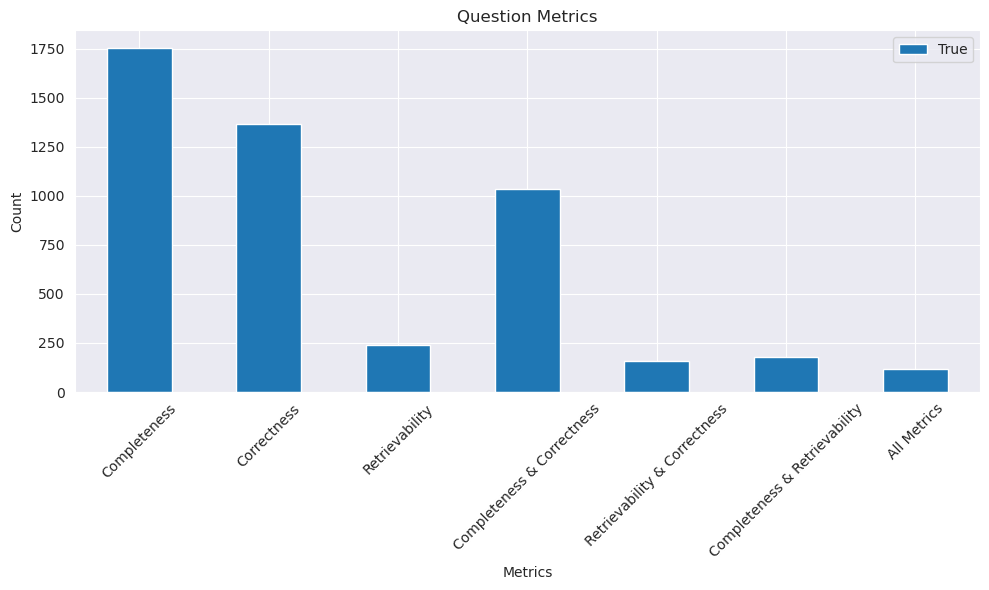

In [23]:
import pandas as pd


# bar plot the number of questions with completeness, correctness and retrievability
def plot_metrics(results):
    completeness = [result["completeness"] for result in results]
    correctness = [result["correctness"] for result in results]
    retrievability = [result["retrievability"] for result in results]
    completeness_correctness = [result["completeness"] and result["correctness"] for result in results]
    retrievability_correctness = [result["retrievability"] and result["correctness"] for result in results]
    completeness_retrievability = [result["completeness"] and result["retrievability"] for result in results]
    completeness_correctness_retrievability = [
        result["completeness"] and result["correctness"] and result["retrievability"]
        for result in results
    ]
    

    metrics_df = pd.DataFrame({
        "Completeness": completeness,
        "Correctness": correctness,
        "Retrievability": retrievability,
        "Completeness & Correctness": completeness_correctness,
        "Retrievability & Correctness": retrievability_correctness,
        "Completeness & Retrievability": completeness_retrievability,
        "All Metrics": completeness_correctness_retrievability
    })
    # bar plot on true values
    metrics_counts = metrics_df.apply(pd.Series.value_counts).fillna(0).astype(int)
    metrics_counts = metrics_counts[metrics_counts.index == True]
    metrics_counts = metrics_counts.T
    metrics_counts.plot(kind='bar', figsize=(10, 6))
    plt.title("Question Metrics")
    plt.xlabel("Metrics")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    
    
# plot the metrics
plot_metrics(results)

In [23]:
# load the question-answer pairs from the json file
import json
import os
import yaml
from datasets import Dataset 

with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Initialize OpenAI client
api_key = config['api-endpoint']['api_key']

os.environ["OPENAI_API_KEY"] = api_key 

json_file = "../data/generated/AT0000A2VDG3_qa_pairs_with_refs.json"
with open(json_file, "r") as f:
    qa_pairs = json.load(f)
    
sample_qa = qa_pairs[:10]
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
from ragas import evaluate
# compute faithfulness
contexts = [qa_pair["reference"]["chunk_text"] for qa_pair in sample_qa]
for qa_pair in sample_qa:
    question = qa_pair["question"]
    answer = qa_pair["answer"]
    context = qa_pair["reference"]["chunk_text"]
    data_sample = {
        "question": [question],
        "answer": [answer],
        "contexts": [[qa_pair["reference"]["chunk_text"]]],
        "ground_truth": [answer]
    }
    print(f"Computing faithfulness, answer_relevancy, context_recall for question: {question}, answer: {answer}")
    score = evaluate(Dataset.from_dict(data_sample), metrics=[faithfulness, answer_relevancy, context_recall])
    print('faithfulness', score["faithfulness"])
    print('answer_relevancy', score["answer_relevancy"])
    print('context_recall', score["context_recall"])
    qa_pair["faithfulness"] = score["faithfulness"]
    qa_pair["answer_relevancy"] = score["answer_relevancy"]
    qa_pair["context_recall"] = score["context_recall"]
    # compute context precision and context recall
    data_sample["contexts"] = [contexts]
    #data_sample["ground_truth"] = [answer]
    print(f"Computing context precision and recall for question: {question}, answer: {answer}")
    score = evaluate(Dataset.from_dict(data_sample), metrics=[context_precision])
    print('context_precision', score["context_precision"])
    qa_pair["context_precision"] = score["context_precision"]

Computing faithfulness, answer_relevancy, context_recall for question: Welche rechtlichen Bedingungen gelten für den Verkauf von Schuldverschreibungen an Kleinanleger im Europäischen Wirtschaftsraum (EWR) laut den Endgültigen Bedingungen vom 28.01.2022?, answer: Die Schuldverschreibungen sind nicht zum Angebot, zum Verkauf oder zur sonstigen Zurverfügungstellung an Kleinanleger im Europäischen Wirtschaftsraum bestimmt und sollten Kleinanlegern im EWR nicht angeboten, nicht an diese verkauft und diesen auch nicht in sonstiger Weise zur Verfügung gestellt werden.


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

faithfulness [1.0]
answer_relevancy [0.0]
context_recall [1.0]
Computing context precision and recall for question: Welche rechtlichen Bedingungen gelten für den Verkauf von Schuldverschreibungen an Kleinanleger im Europäischen Wirtschaftsraum (EWR) laut den Endgültigen Bedingungen vom 28.01.2022?, answer: Die Schuldverschreibungen sind nicht zum Angebot, zum Verkauf oder zur sonstigen Zurverfügungstellung an Kleinanleger im Europäischen Wirtschaftsraum bestimmt und sollten Kleinanlegern im EWR nicht angeboten, nicht an diese verkauft und diesen auch nicht in sonstiger Weise zur Verfügung gestellt werden.


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

context_precision [0.99999999999]
Computing faithfulness, answer_relevancy, context_recall for question: Was ist der Erstausgabekurs der 0,625% Erste Group Festzinsanleihe 22-29?, answer: Der Erstausgabekurs beträgt 100,00%.


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
from pathlib import Path
in_dir = Path("/home/adrian/workspace/qa-generator-with-human-review/data/generated")
json_file = list(in_dir.glob("*.json"))
qa_count = 0
for json_file in json_file:
    with open(json_file, "r") as f:
        qa_pairs = json.load(f)
        qa_count += len(qa_pairs)
print(f"Total number of question-answer pairs: {qa_count}")

Total number of question-answer pairs: 292
